In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
# finalize model and make a prediction for monthly births with random forest
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from numpy import asarray
from numpy import array
from pandas import concat
from sklearn.ensemble import RandomForestRegressor
import joblib

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [2]:
# data_path = "/content/drive/MyDrive/Colab Notebooks/Hitachi/Data/final_data.csv"
data_path = "final_data.csv"
data_df = pd.read_csv(data_path)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27552 entries, 0 to 27551
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      27552 non-null  int64  
 1   datetime                        27552 non-null  object 
 2   Demand (MW)                     27552 non-null  float64
 3   Temperature                     27552 non-null  float64
 4   dewpoint                        27552 non-null  float64
 5   humidity                        27552 non-null  float64
 6   precipitation                   27552 non-null  float64
 7   precipprob                      27552 non-null  float64
 8   snow                            27552 non-null  float64
 9   snowdepth                       27552 non-null  float64
 10  windgust                        27552 non-null  float64
 11  windspeed                       27552 non-null  float64
 12  sealevelpressure                

In [3]:
data_df.head()

,Unnamed: 0,datetime,Demand (MW),Temperature,dewpoint,humidity,precipitation,precipprob,snow,snowdepth,...,ice,rain,snow.1,Clear,Freezing Drizzle/Freezing Rain,Ice,Overcast,Partially cloudy,Rain,Snow
0,0,2020-01-01 00:00:00,445.8,38.0,29.0,69.76,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
1,1,2020-01-01 01:00:00,424.5,38.0,29.9,72.37,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
2,2,2020-01-01 02:00:00,423.5,38.0,30.8,75.06,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
3,3,2020-01-01 03:00:00,418.8,37.1,29.9,74.97,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,4,2020-01-01 04:00:00,414.8,35.1,29.0,78.41,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0


In [4]:
data_df['datetime'] = pd.to_datetime(data_df['datetime'])

# Extract date and time components
data_df['date'] = data_df['datetime'].dt.date
data_df['time'] = data_df['datetime'].dt.time

In [5]:
data_df.head()

,Unnamed: 0,datetime,Demand (MW),Temperature,dewpoint,humidity,precipitation,precipprob,snow,snowdepth,...,snow.1,Clear,Freezing Drizzle/Freezing Rain,Ice,Overcast,Partially cloudy,Rain,Snow,date,time
0,0,2020-01-01 00:00:00,445.8,38.0,29.0,69.76,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,2020-01-01,00:00:00
1,1,2020-01-01 01:00:00,424.5,38.0,29.9,72.37,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,2020-01-01,01:00:00
2,2,2020-01-01 02:00:00,423.5,38.0,30.8,75.06,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,2020-01-01,02:00:00
3,3,2020-01-01 03:00:00,418.8,37.1,29.9,74.97,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,2020-01-01,03:00:00
4,4,2020-01-01 04:00:00,414.8,35.1,29.0,78.41,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,2020-01-01,04:00:00


In [6]:
data_df["time"] = data_df["time"].astype(str)

In [7]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# Hour Demand Forecasting Models

In [8]:
hourlist = []
for i in range(0, 24):
    if len(str(i)) == 1:
        hourlist.append(f"0{i}:00:00")
    else:
        hourlist.append(f"{i}:00:00")
hourlist

['00:00:00',
 '01:00:00',
 '02:00:00',
 '03:00:00',
 '04:00:00',
 '05:00:00',
 '06:00:00',
 '07:00:00',
 '08:00:00',
 '09:00:00',
 '10:00:00',
 '11:00:00',
 '12:00:00',
 '13:00:00',
 '14:00:00',
 '15:00:00',
 '16:00:00',
 '17:00:00',
 '18:00:00',
 '19:00:00',
 '20:00:00',
 '21:00:00',
 '22:00:00',
 '23:00:00']

In [9]:
def plot_truth_vs_pred(test_y, test_prediction, number_to_plot):
    pred_df = pd.DataFrame({'ground_truth' : test_y[:number_to_plot], 'prediction' : test_prediction[:number_to_plot]})
    sns.lineplot(data=pred_df)
    plt.title(f"Ground Truth vs Predicted Demand {hour}")
    
for hour in hourlist:
    hour_data_df = data_df[data_df["time"] == hour]
    hour_data_df.reset_index(inplace=True)
    # hour_data_df.head()

    series = pd.DataFrame(hour_data_df["Demand (MW)"])
    values = series.values
    # Use first 10% of dataset as the test dataset
    # Use 90 % of data as train dataset
    # 10% of total data (27552) = 5510
    first_20_percent_index = int(0.1 * len(values))
    train_values = values[first_20_percent_index:, :]
    test_values = values[:first_20_percent_index, :]
    # print(train_values.shape, test_values.shape)
    
    
    # 3 weeks of data is used as prior data => 24 * 7 * 3 = 504
    number_of_weeks = 3
    previous_data_dependency_hours = 7*number_of_weeks
    # transform the time series data into supervised learning
    train_supervised_data = series_to_supervised(train_values, n_in=previous_data_dependency_hours)
    test_supervised_data = series_to_supervised(test_values, n_in=previous_data_dependency_hours)
    # print(train_supervised_data.shape)
    
    train_X, train_y = train_supervised_data[:, :-1], train_supervised_data[:, -1]
    # print(train_X.shape)
    
    # fit model
    n_estimators = 1000
    model = RandomForestRegressor(n_estimators=n_estimators, verbose=0, n_jobs=-1)
    model.fit(train_X, train_y)
    
    model_path = f"MODEL ARCHIVE/HOUR MODEL/rfr_{hour}.pkl"
    print(f"Saving model {model_path}")
    # model_path = f"/content/drive/MyDrive/Colab Notebooks/Hitachi/MODEL ARCHIVE/HOUR MODEL/rfr_{hour}.pkl"
    save_model = True
    if save_model:
        joblib.dump(model, model_path)

Saving model MODEL ARCHIVE/HOUR MODEL/rfr_00:00:00.pkl
Saving model MODEL ARCHIVE/HOUR MODEL/rfr_01:00:00.pkl
Saving model MODEL ARCHIVE/HOUR MODEL/rfr_02:00:00.pkl
Saving model MODEL ARCHIVE/HOUR MODEL/rfr_03:00:00.pkl
Saving model MODEL ARCHIVE/HOUR MODEL/rfr_04:00:00.pkl
Saving model MODEL ARCHIVE/HOUR MODEL/rfr_05:00:00.pkl
Saving model MODEL ARCHIVE/HOUR MODEL/rfr_06:00:00.pkl
Saving model MODEL ARCHIVE/HOUR MODEL/rfr_07:00:00.pkl
Saving model MODEL ARCHIVE/HOUR MODEL/rfr_08:00:00.pkl
Saving model MODEL ARCHIVE/HOUR MODEL/rfr_09:00:00.pkl
Saving model MODEL ARCHIVE/HOUR MODEL/rfr_10:00:00.pkl
Saving model MODEL ARCHIVE/HOUR MODEL/rfr_11:00:00.pkl
Saving model MODEL ARCHIVE/HOUR MODEL/rfr_12:00:00.pkl
Saving model MODEL ARCHIVE/HOUR MODEL/rfr_13:00:00.pkl
Saving model MODEL ARCHIVE/HOUR MODEL/rfr_14:00:00.pkl
Saving model MODEL ARCHIVE/HOUR MODEL/rfr_15:00:00.pkl
Saving model MODEL ARCHIVE/HOUR MODEL/rfr_16:00:00.pkl
Saving model MODEL ARCHIVE/HOUR MODEL/rfr_17:00:00.pkl
Saving mod

## Validation of the model

Loading model MODEL ARCHIVE/HOUR MODEL/rfr_09:00:00.pkl


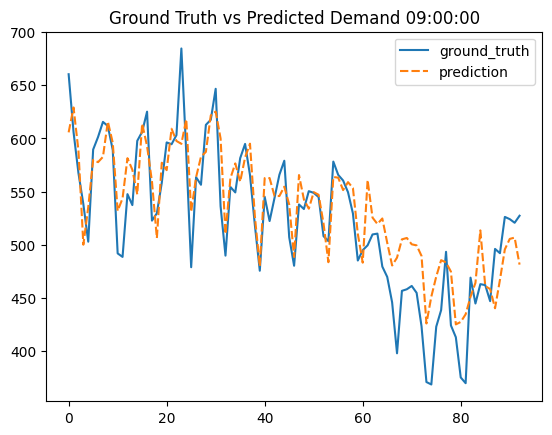

In [10]:
hour = "09:00:00"
model_path = f"MODEL ARCHIVE/HOUR MODEL/rfr_{hour}.pkl"
print(f"Loading model {model_path}")
loaded_model = joblib.load(model_path)

hour_data_df = data_df[data_df["time"] == hour]
hour_data_df.reset_index(inplace=True)
# hour_data_df.head()

series = pd.DataFrame(hour_data_df["Demand (MW)"])
values = series.values
# Use first 10% of dataset as the test dataset
# Use 90 % of data as train dataset
# 10% of total data (27552) = 5510
first_20_percent_index = int(0.1 * len(values))
test_values = values[:first_20_percent_index, :]
# print(train_values.shape, test_values.shape)

# 3 weeks of data is used as prior data => 24 * 7 * 3 = 504
number_of_weeks = 3
previous_data_dependency_hours = 7*number_of_weeks
# transform the time series data into supervised learning
test_supervised_data = series_to_supervised(test_values, n_in=previous_data_dependency_hours)

test_X, test_y = test_supervised_data[:, :-1], test_supervised_data[:, -1]
test_prediction = loaded_model.predict(test_X)

plot_truth_vs_pred(test_y, test_prediction, number_to_plot=test_prediction.shape[0])

In [12]:
print(mean_squared_error(test_y, test_prediction))
print(mean_absolute_percentage_error(test_y, test_prediction))
print(mean_absolute_error(test_y, test_prediction))

1219.9069135750713
0.057688085360849475
28.431931182795832


In [13]:
test_X.shape

(93, 21)